# Imports and definitions

In [1]:
from XRDXRFutils.notebook_utils import *
from utility_functions import *
from scipy.io import loadmat


### Size of the detector ###
n_channels = 1280
length_channel = 50 * 10**(-4)   # in cm
width_channel = 0.8
L = n_channels * length_channel   # length of the detector

### Base path ###
#path_shared = '/home/shared/'
path_shared = '../../shared/'
list_path_database = [path_shared + 'Database/']   # tabulated phases

# Read phase database

In [2]:
print('Reading phases from: ' + ', '.join(["'" + path + "'" for path in list_path_database]))
database = DatabaseXRD()
for path_database in list_path_database:
    database.read_cifs(path_database)
print(f'Total number of phases: {len(database)}')

Reading phases from: '../../shared/Database/'
Total number of phases: 369


### Explore phases

In [3]:
elements_chosen = ['Al']
elements_excluded = []

df_phases = DataFrame(columns = ['Name in database', 'Chemical formula', 'N. of samples'])
for phase_name, phase_set in sorted(database.items()):
    p = phase_set[0]
    if '_chemical_formula_sum' in p:
        if (all(is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_chosen)
            and all(not is_element_in_formula(e, p['_chemical_formula_sum']) for e in elements_excluded)):
            df_phases.loc[len(df_phases)] = [phase_name, p['_chemical_formula_sum'], len(phase_set)]
elements_excluded = []
df_phases

,Name in database,Chemical formula,N. of samples
0,Al (O H)3,Al H3 O3,3
1,Al K O2,Al K O2,1
2,Al2 Co O4,Al2 Co O4,2
3,Al2 O3,Al2 O3,10
4,Alum-K,Al H24 K O20 S2,1
5,Aluminium oxide,Al2 O3,1
6,Aluminium oxide - $-theta,Al2 O3,1
7,Aluminium oxide - \k,Al2 O3,1
8,Aluminoceladonite,Al1.788 H2 K Mg0.64 O12 Si3.572,3
9,Attakolite,Al4 Ca H5 Mn O20 P3 Si,1


# Read experimental data

### Angelo

In [26]:
data = DataXRD().load_h5('../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5')
x = 120
y = 150
intensity = data.data[y, x]
incident = 10.5
d = 3
omega = 0.02
psi = 0.78
opt = array([-1163.94491637, 2040.63657082, 50.71024209])
a, s, beta = opt[0] * length_channel, opt[1] * length_channel, opt[2]
theta_min, theta_max = 23, 50

### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 10  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 3          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

### Phase for fit ###
phase = database['Hydrocerussite'][0]

Loading: ../../shared/dataXRDXRF/Perugia/PieroDellaFrancesca/Cimasa/AngeloXRD/xrd.h5


### 20-70, no slit

In [37]:
i = 28 #28

###

mat = loadmat('dati_sperimentali_2/det6cm2theta35degsample10degNOFenditura.mat')
data = mat['M'][0]
print(f'Shape of data: {data.shape}')
print(f'Length of first element: {len(data[0])}')

# Reading
intensity = asarray(data[i][3], dtype = float)[:, 0]
d = asarray(data[i][4], dtype = float)[0][0]

peaks_value_calib = asarray(data[0][14], dtype = float).reshape([-1, 3])[:-1]
peaks_error_calib = asarray(data[0][15], dtype = float).reshape([-1, 3])[:-1]
peaks_position_angle = peaks_value_calib[:, 1]
peaks_sigma = peaks_value_calib[:, 2]
peaks_error_sigma = peaks_error_calib[:, 2]

R, gamma, alpha = asarray(data[i][12], dtype = float)[:, 0]
a, s, beta = R_alpha_gamma__to__a_s_beta(R, alpha, gamma, L)
theta_min, theta_max = asarray(data[i][13], dtype = float)[[0, -1], 0]
incident = data[0][21][0, 0]
divergence = asarray(data[i][25], dtype = float)[0, 0]
beam_size = asarray(data[i][26], dtype = float)[0]
beam_footprint = asarray(data[i][27], dtype = float)

# My calculations
omega = divergence / 2
psi = divergence / 2
beam_size_calc = 2 * d * tan(deg2rad(array([omega, psi])))
beam_footprint_calc = d * array([
    deg2rad(array([+ omega, - omega])) / sin(deg2rad(incident)),
    tan(deg2rad(array([- psi, + psi])))
]).T

### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 100  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 5          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

### Phase for fit ###
phase = database['Aluminium oxide'][0]

print(f'Angular range = {theta_min, theta_max}')
print(f'd = {d}')
print(f'i = {incident}')
print(f'div = {divergence}')
#print(f'R = {R}, alpha = {alpha}, gamma = {gamma}')
print(f'a = {a}, s = {s}, beta = {beta}')
print(f'Beam size (read) = {beam_size}')
print(f'beam size (calculated) = {beam_size_calc}')
print(f'Beam footprint (read) = \n{beam_footprint}')
print(f'Beam footprint (calculated) = \n{beam_footprint_calc}')

Shape of data: (29,)
Length of first element: 37
Angular range = (20.826106661342866, 73.18190336304461)
d = 0.1
i = 10
div = 0.78
a = -0.931690096795418, s = 5.807237177260221, beta = 29.916692849820045
Beam size (read) = [0.02936136 0.02936136]
beam size (calculated) = [0.00136138 0.00136138]
Beam footprint (read) = 
[[ 0.08321635 -0.01467329]
 [-0.08325826  0.01468068]]
Beam footprint (calculated) = 
[[ 0.00391856 -0.00068069]
 [-0.00391856  0.00068069]]


### 20-70, slit 600 $\mu$m

In [70]:
i = 0 #32

###

mat = loadmat('dati_sperimentali_2/det8cm2theta35degsample10degFenditura600um.mat')
mat['M'][0].shape
data = mat['M'][0]
print(f'Shape of data: {data.shape}')
print(f'Length of first element: {len(data[0])}')

# Reading
intensity = asarray(data[i][5], dtype = float)[:, 0]
d = asarray(data[i][6], dtype = float)[0][0]

peaks_value_calib = asarray(data[0][16], dtype = float).reshape([-1, 3])[:-1]
peaks_error_calib = asarray(data[0][17], dtype = float).reshape([-1, 3])[:-1]
peaks_position_angle = peaks_value_calib[:, 1]
peaks_sigma = peaks_value_calib[:, 2]
peaks_error_sigma = peaks_error_calib[:, 2]

R, gamma, alpha = asarray(data[i][13], dtype = float)[:, 0]
a, s, beta = R_alpha_gamma__to__a_s_beta(R, alpha, gamma, L)
theta_min, theta_max = asarray(data[i][15], dtype = float)[[0, -1], 0]
incident = data[0][22][0, 0]
div_x = asarray(data[i][26], dtype = float)[0, 0]
div_y = asarray(data[i][27], dtype = float)[0, 0]
beam_size = asarray(data[i][28], dtype = float)[0]
beam_footprint = asarray(data[i][29], dtype = float)

# My calculations
omega = div_y / 2
psi = div_x / 2
beam_size_calc = 2 * d * tan(deg2rad(array([omega, psi])))
beam_footprint_calc = d * array([
    deg2rad(array([+ omega, - omega])) / sin(deg2rad(incident)),
    tan(deg2rad(array([- psi, + psi])))
]).T

### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 10  # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 2          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

### Phase for fit ###
phase = database['Aluminium oxide'][0]

print(f'Angular range = {theta_min, theta_max}')
print(f'd = {d}')
print(f'i = {incident}')
print(f'divergence = {div_x, div_y}')
print(f'R = {R}, alpha = {alpha}, gamma = {gamma}')
print(f'a = {a}, s = {s}, beta = {beta}')
print(f'Beam size (read) = {beam_size}')
print(f'beam size (calculated) = {beam_size_calc}')
print(f'Beam footprint (read) = \n{beam_footprint}')
print(f'Beam footprint (calculated) = \n{beam_footprint_calc}')

Shape of data: (33,)
Length of first element: 43
Angular range = (27.756493829200018, 67.5745190302715)
d = 0.1
i = 10
divergence = (1.0, 0.02)
R = 8.55250295526358, alpha = 49.60785885838259, gamma = 56.83071837450779
a = -0.7797502921043757, s = 8.202907908249575, beta = 33.16928162549221
Beam size (read) = [0.02174533 0.02003491]
beam size (calculated) = [3.49065854e-05 1.74537356e-03]
Beam footprint (read) = 
[[ 0.0567832  -0.01001241]
 [-0.0568118   0.01001745]]
Beam footprint (calculated) = 
[[ 0.00010048 -0.00087269]
 [-0.00010048  0.00087269]]


### Venere

In [45]:
i = 0

###

mat = loadmat('dati_sperimentali_2/CalibrazioneVenere.mat')
mat['M'][0].shape
data = mat['M'][0]
print(f'Shape of data: {data.shape}')
print(f'Length of first element: {len(data[0])}\n')

# Reading
fold = data[i][0][0]
intensity = asarray(data[i][2], dtype = float)[:, 0]
d = asarray(data[0][3], dtype = float)[0][0]

peaks_value_calib = asarray(data[0][9], dtype = float).reshape([-1, 3])[:-1]
peaks_error_calib = asarray(data[0][10], dtype = float).reshape([-1, 3])[:-1]
peaks_position_angle = peaks_value_calib[:, 1]
peaks_sigma = peaks_value_calib[:, 2]
peaks_error_sigma = peaks_error_calib[:, 2]

R, gamma, alpha = asarray(data[0][6], dtype = float)[:, 0]
a, s, beta = R_alpha_gamma__to__a_s_beta(R, alpha, gamma, L)
theta_min, theta_max = asarray(data[0][8], dtype = float)[[0, -1], 0]
incident = data[0][14][0, 0]
div = asarray(data[0][18], dtype = float)[0, 0]
beam_size = asarray(data[0][19], dtype = float)[0]
beam_footprint = asarray(data[0][20], dtype = float)

# My calculations
omega = div / 2
psi = div / 2
beam_size_calc = 2 * d * tan(deg2rad(array([omega, psi])))
beam_footprint_calc = d * array([
    deg2rad(array([+ omega, - omega])) / sin(deg2rad(incident)),
    tan(deg2rad(array([- psi, + psi])))
]).T

### Smoothing options ###
window_snip = 32        # width of the window used for determining the background (default 32)
offset_background = 1   # value added to the background, before subtracting it from the raw signal (default 0)
std_smooth = 2          # Float: strength of the final smooth applied to the XRD pattern (standard deviation of the Gaussian kernel used in the convolution)

### Phase for fit ###
phase = database['Aluminium oxide'][0]

print(f'Fold = {fold}')
print(f'Angular range = {theta_min, theta_max}')
print(f'd = {d}')
print(f'i = {incident}')
print(f'divergence = {div}')
print(f'R = {R}, alpha = {alpha}, gamma = {gamma}')
print(f'a = {a}, s = {s}, beta = {beta}')
print(f'Beam size (read) = {beam_size}')
print(f'beam size (calculated) = {beam_size_calc}')
print(f'Beam footprint (read) = \n{beam_footprint}')
print(f'Beam footprint (calculated) = \n{beam_footprint_calc}')

Shape of data: (5,)
Length of first element: 34

Fold = Allumina600s\
Angular range = (16.05306131995042, 44.1933093866209)
d = 1.8
i = 10.5
divergence = 1.0
R = 12.525787419326436, alpha = 29.425679629843653, gamma = 48.90805995912489
a = -5.7328473441871495, s = 12.267030398804778, beta = 41.09194004087511
Beam size (read) = [0.05141593 0.02062832]
beam size (calculated) = [0.03141672 0.03141672]
Beam footprint (read) = 
[[ 0.05562221 -0.01030897]
 [-0.05565022  0.01031416]]
Beam footprint (calculated) = 
[[ 0.08619594 -0.01570836]
 [-0.08619594  0.01570836]]


# Analyse data

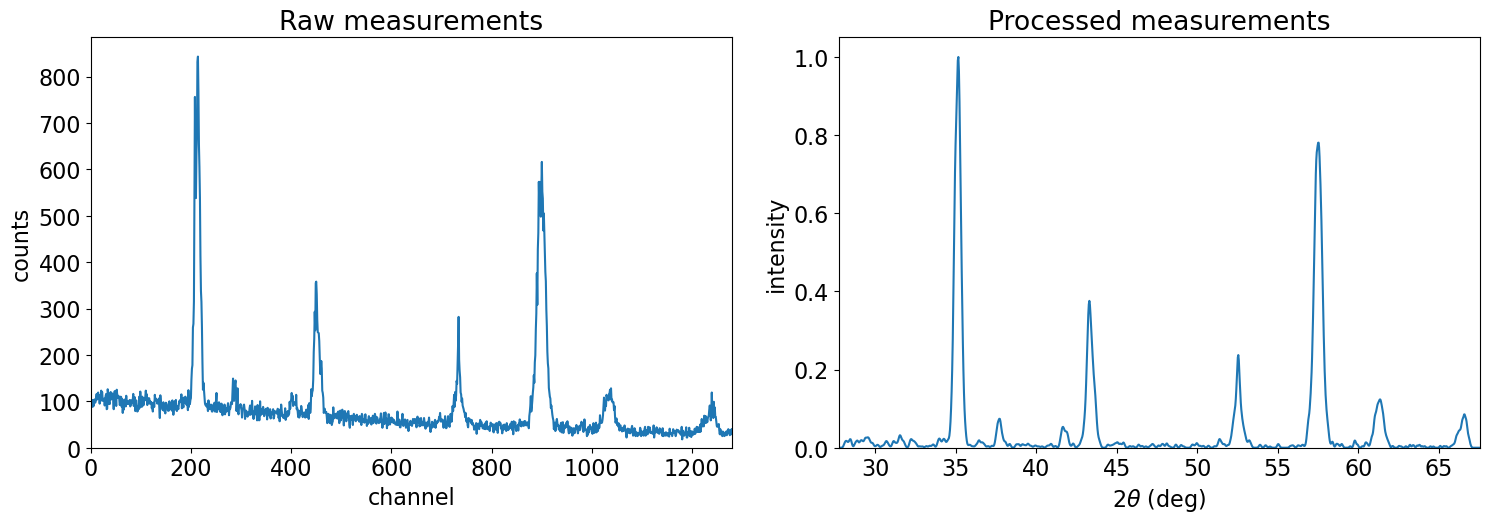

In [71]:
spectrum = (
    FastSpectraXRD()
    .from_array(intensity)
    .remove_background(window_snip = window_snip, offset_background = offset_background)
    .smooth_channels(std_kernel = std_smooth)
    .calibrate_from_parameters([a / length_channel, s / length_channel, beta])
)
gn = GaussNewton(phase, spectrum, sigma = 0.2, min_theta = theta_min, max_theta = theta_max, min_intensity = 0.05, distance_merge = 0.2)

### Plot ###
rcParams['font.size'] = 16

fig, axs = subplots(1, 2, figsize = (15, 5))
fig.tight_layout(w_pad = 2)

ax = axs[0]
ax.plot(spectrum.channel, spectrum.counts)
ax.set_xlim(spectrum.channel[[0, -1]])
ax.set_ylim(0, None)
ax.set_xlabel('channel')
ax.set_ylabel('counts')
ax.set_title('Raw measurements')

ax = axs[1]
ax.plot(spectrum.theta, spectrum.intensity)
ax.set_xlim(*gn.theta_range())
ax.set_ylim(0, None)
ax.set_xlabel(r'$2 \theta$ (deg)')
ax.set_ylabel('intensity')
ax.set_title('Processed measurements')

show()

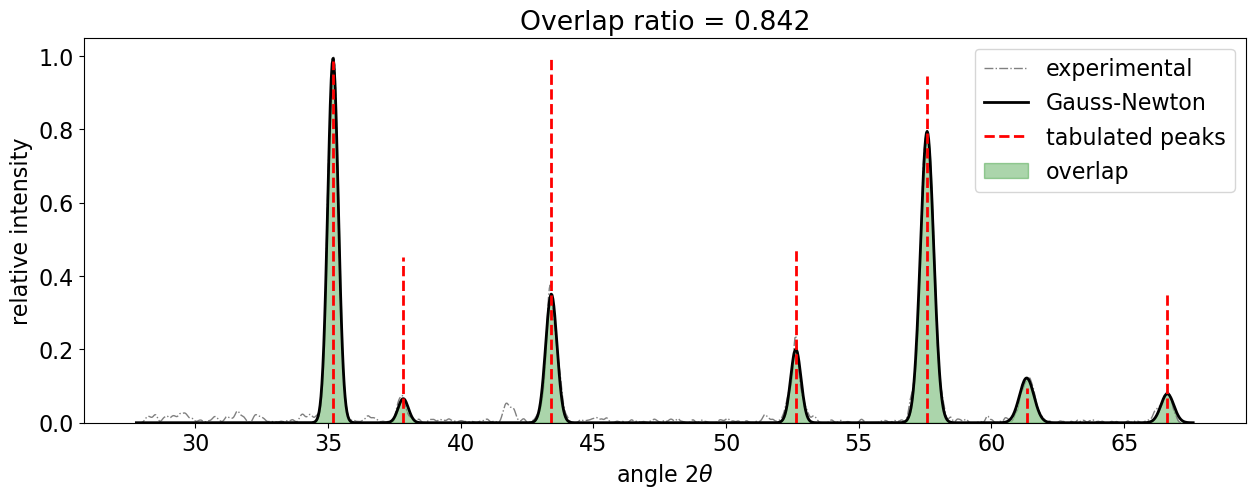

opt = [-147.03832917 1635.89065047   32.91984467]
theta range = [27.78374487 67.60131076]
angle = [35.19259793 37.83864357 43.41865524 52.62991361 57.57608248 61.32836499
 66.62780516]
sigma = [0.19787415 0.19337127 0.21378095 0.19558753 0.2489078  0.27305295
 0.24396559]


In [74]:
rcParams['font.size'] = 16
fig, ax = subplots(figsize = (15, 5))
sca(ax)
gn.plot_spectrum(c = 'grey', ls = '-.', lw = 1, label = 'experimental')
gn.plot(c = 'black', ls = '-', lw = 2, label = 'Gauss-Newton')
gn.plot_phase(lw = 2, alpha = 1, label = 'tabulated peaks')
ax.fill_between(gn.theta.squeeze(), gn.overlap(), color = 'g', alpha = 0.33, label = 'overlap')
ax.legend(frameon = True, loc = 'upper right')
#ax.set_xlim(min_theta - 1, max_theta + 1)
ax.set_ylim(0, 1.05)
ax.set_xlabel(r'angle $2\theta$')
ax.set_ylabel(r'relative intensity')
ax.set_title(f'Overlap ratio = {gn.overlap_area_ratio():.3f}')
show()

print(f'opt = {gn.opt}')
print(f'theta range = {gn.theta_range()}')
print(f'angle = {gn.mu}')
print(f'sigma = {sqrt(gn.sigma2.squeeze())}')

In [73]:
gn = gn.fit_cycle(steps = 32, a = True, s = True, beta = True, gamma = True, sigma = True)
a, s, beta = gn.opt[0] * length_channel, gn.opt[1] * length_channel, gn.opt[2]
theta_min, theta_max = gn.theta_range()

# Model

### Plot positions

a, s = -0.735, 8.179
beta = 32.919844671339554
d/L = 0.016
d = 0.100 cm
i = 10
theta = 30


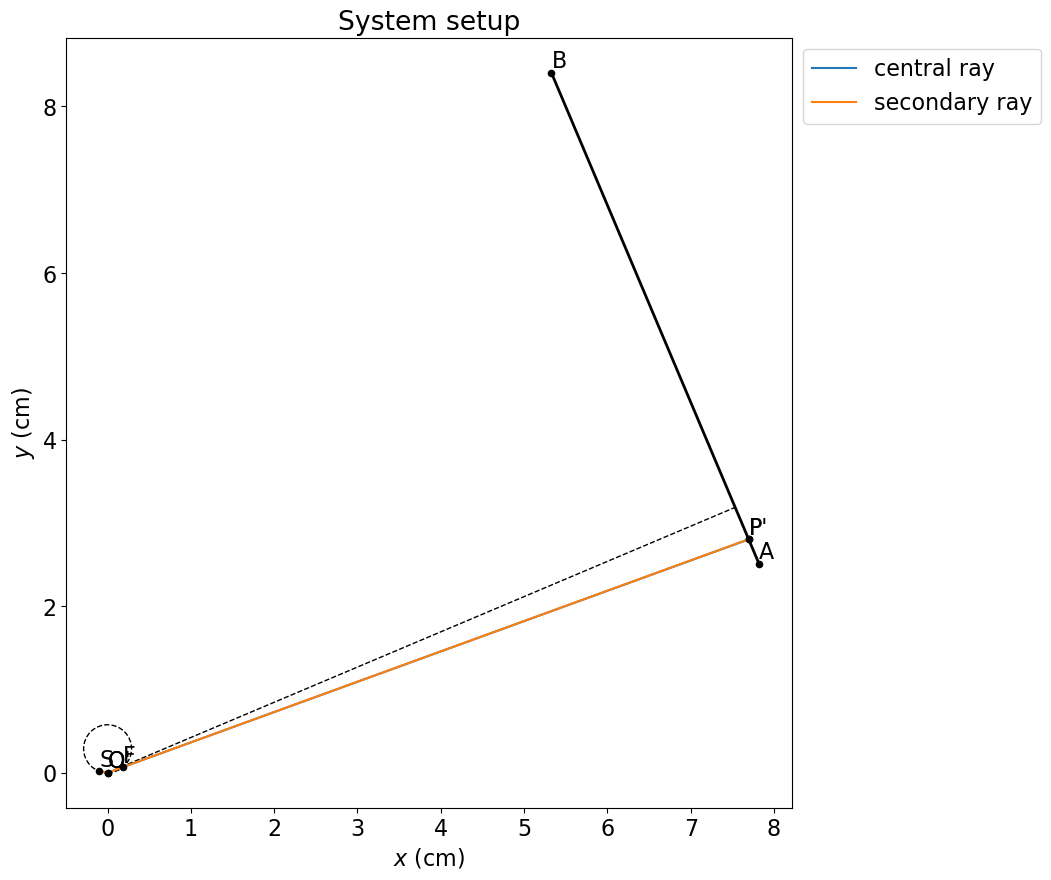

Df = 7.993 cm
Dp = 0.001 cm (0.279 channels)
Dtheta = 0.010 deg


In [75]:
omega_plot = omega   # Deviation angle of the followed secondary ray

### Diffraction ###
#theta = (theta_min + theta_max) / 2
theta = 30

### Plot ###
rcParams['font.size'] = 16
plot_secondary_ray = True

###

print(f'a, s = {a:.3f}, {s:.3f}')
print(f'beta = {beta}')
print(f'd/L = {d/L:.3f}')
print(f'd = {d:.3f} cm')
print(f'i = {incident}')
print(f'theta = {theta}')

### Figure ###
fig, ax = subplots(figsize = (10, 10))
plot_experimental_setting(L, a, s, beta, incident, d, omega_plot, theta, ax, legend = True, secondary_ray = plot_secondary_ray)
show()

Delta_f, Delta_p, Delta_theta = error_defocus(theta, a, s, beta, incident, d, omega_plot)
print(f'Df = {Delta_f:.3f} cm')
print(f'Dp = {Delta_p:.3f} cm ({Delta_p / length_channel:.3f} channels)')
print(f'Dtheta = {Delta_theta:.3f} deg')

### Plot diffraction conic

theta = 30 deg
p(P') = 0.319 cm
p(P'') = 0.317 cm
p(D') = 0.296 cm
p(D'') = 0.293 cm
Delta p = 0.013226151567402727 cm
Delta p = 0.013226151567402727 cm


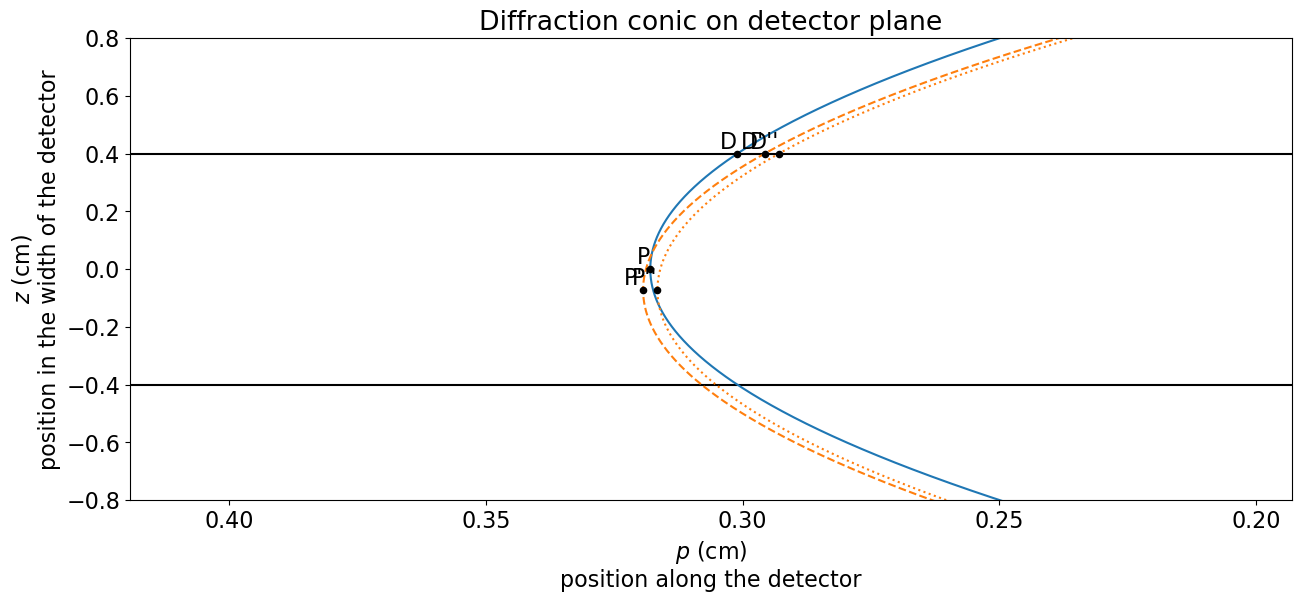

In [76]:
sigma_omega_plot = omega #0.67   # Angular disperion of the beam (direction 1)
sigma_psi_plot = psi #sigma_omega_plot   # Angular disperion of the beam (direction 2)

### Calculate intersection curve ###
arr_z = arange(- 20 * width_channel, 20 * width_channel, 0.0001)
arr_p = conic_diffraction_base(arr_z, theta, a, s, beta)
Delta_z = ( d + s / cos(deg2rad(theta - beta)) ) * tan(deg2rad(sigma_psi_plot))
arr_p1 = conic_diffraction(arr_z, theta, a, s, beta, d, incident, sigma_omega_plot, -sigma_psi_plot)
arr_p2 = conic_diffraction(arr_z, theta, a, s, beta, d, incident, -sigma_omega_plot, -sigma_psi_plot)

### Calculate coordinates and distances ###
x_P = angle_to_distance(theta, a, s, beta)
x_D = conic_diffraction_base(width_channel/2, theta, a, s, beta)[0]
x_P1 = conic_diffraction(0, theta, a, s, beta, d, incident, sigma_omega_plot, 0)[0]
x_D1 = conic_diffraction(width_channel/2, theta, a, s, beta, d, incident, sigma_omega_plot, -sigma_psi_plot)[0]
x_P2 = conic_diffraction(0, theta, a, s, beta, d, incident, -sigma_omega_plot, 0)[0]
x_D2 = conic_diffraction(width_channel/2, theta, a, s, beta, d, incident, -sigma_omega_plot, -sigma_psi_plot)[0]
Delta_p = 0.5 * (max(x_P1, x_D1, x_P2, x_D2) - min(x_P1, x_D1, x_P2, x_D2))
Delta_p_alt, _ = error_defocus_and_cone(width_channel, theta, a, s, beta, d, incident, sigma_omega_plot, sigma_psi_plot)

print(f'theta = {theta} deg')
print(f'p(P\') = {x_P1:.3f} cm')
print(f'p(P\'\') = {x_P2:.3f} cm')
print(f'p(D\') = {x_D1:.3f} cm')
print(f'p(D\'\') = {x_D2:.3f} cm')
print(f'Delta p = {Delta_p} cm')
print(f'Delta p = {Delta_p_alt} cm')

### Plot ###
fig, ax = subplots(figsize = (15, 6))
ax.plot([0, 0], [- width_channel/2, width_channel/2], c = 'black')
ax.plot([L, L], [- width_channel/2, width_channel/2], c = 'black')
ax.plot([0, L], [- width_channel/2, - width_channel/2], c = 'black')
ax.plot([0, L], [width_channel/2, width_channel/2], c = 'black')
ax.plot(arr_p[0], arr_z, c = 'tab:blue')
ax.plot(arr_p[1], arr_z, c = 'tab:blue')
ax.plot(arr_p1[0], arr_z, ls = '--', c = 'tab:orange')
ax.plot(arr_p2[0], arr_z, ls = ':', c = 'tab:orange')

ax.scatter(0, 0, c = 'black', s = 20, zorder = 2.5)
ax.annotate('A', (0, 0), ha = 'left', va = 'bottom')
ax.scatter(n_channels * length_channel, 0, c = 'black', s = 20, zorder = 2.5)
ax.annotate('B', (n_channels * length_channel, 0), ha = 'right', va = 'bottom')
list_letters = ['P', 'D', 'P\'', 'D\'', 'P\'\'', 'D\'\'']
list_coords = [(x_P, 0), (x_D, width_channel/2), (x_P1, -Delta_z), (x_D1, width_channel/2), (x_P2, -Delta_z), (x_D2, width_channel/2)]
for letter, coords in zip(list_letters, list_coords):
    ax.scatter(*coords, c = 'black', s = 20, zorder = 2.5)
    ax.annotate(letter, coords, ha = 'right', va = 'bottom')

#ax.set_aspect(1)
x_lim_complete = n_channels * length_channel * array([- 0.1, 1.1])
if (not isnan(x_D2)):
    x_lim_narrow = (x_D2 - 0.1, x_P1 + 0.1)
else:
    x_lim_narrow = (- 0.1 * n_channels * length_channel, x_P1 + 0.05)
#ax.set_xlim(n_channels * length_channel * array([- 0.1, 1.1]))
#ax.set_ylim(- 2 * width_channel, 2 * width_channel)
ax.set_xlim(x_lim_narrow)
ax.set_ylim(- 1 * width_channel, 1 * width_channel)

ax.invert_xaxis()
ax.set_xlabel(r'$p$ (cm)' + '\nposition along the detector')
ax.set_ylabel(r'$z$ (cm)' + '\nposition in the width of the detector')
ax.set_title('Diffraction conic on detector plane')
show()

### Angular error

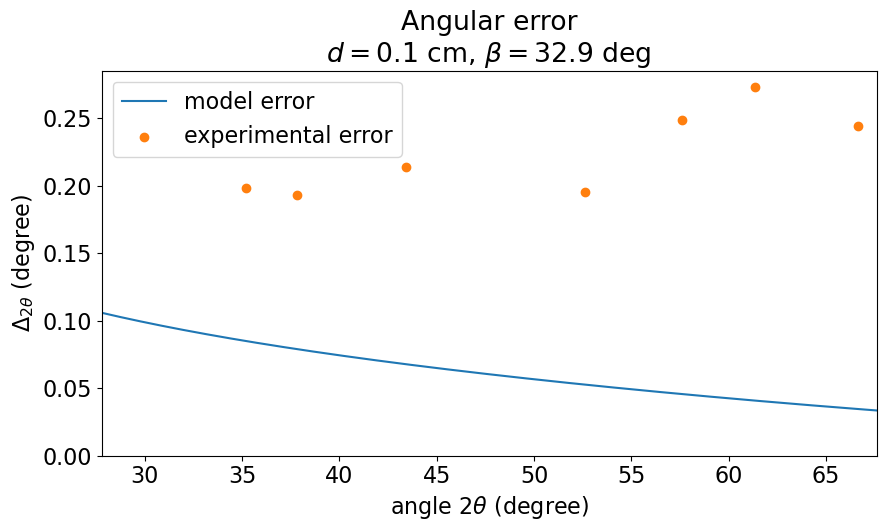

In [77]:
arr_channel_base = arange(0, n_channels, 1)
arr_theta_base = channel_to_angle(arr_channel_base, a, s, beta, length_channel)

### Error from cone ###
# Varying: beta (--> a, s), theta (--> channel)
arr_theta = arr_theta_base
Delta_p, Delta_theta = error_defocus_and_cone(width_channel, arr_theta, a, s, beta, d, incident, omega, psi)
arr_error_cone = Delta_theta

### Error from defocus ###
# Varying: channel (--> theta)
arr_theta = arr_theta_base
arr_error_resolution = error_resolution(arr_theta, a, s, beta, length_channel)

### Total error ###
arr_error_total = sqrt(power(arr_error_cone, 2) + power(arr_error_resolution, 2))

###

fig, ax = subplots(figsize = (10, 5))
ax.plot(arr_theta_base, arr_error_total, label = 'model error')
ax.scatter(gn.mu, sqrt(gn.sigma2.squeeze()), c = 'tab:orange', label = 'experimental error')
#ax.errorbar(peaks_position_angle, peaks_sigma, peaks_error_sigma, marker = 'o', ls = 'None', c = 'tab:green')
ax.legend(frameon = True)
ax.set_xlim(theta_min, theta_max)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2 \theta$ (degree)')
ax.set_ylabel(r'$\Delta_{2\theta}$ (degree)')
ax.set_title('Angular error\n' + r'$d = $' + f'{d:.1f} cm' + r', $\beta = $' + f'{beta:.1f} deg')
show()

# Find best configuration for given $\theta_\textrm{min}$ and $\theta_\textrm{max}$

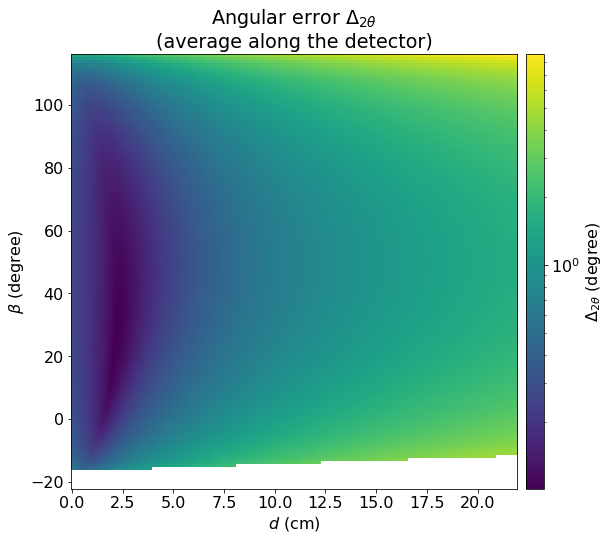

In [128]:
beta_min, beta_max, beta_step = theta_max - 89, theta_min + 89, 1
d_min, d_max, d_step = 0, 22, 0.1   # d (distance of the focus of the source / length of the detector)

###

arr_beta_base = arange(beta_min, beta_max, beta_step)
arr_channel_base = arange(0, n_channels, 5)

### Defocus + cone error ###
# Varying: beta (--> a, s), d, theta (--> channel)

# beta
arr_beta = expand_dims(arr_beta_base, axis = [1, 2])
arr_a, arr_s = a_s_from_beta(arr_beta, L, theta_min, theta_max)
# d
arr_d = expand_dims(arange(d_min, d_max, d_step), axis = [0, 2])
# channel
arr_channel = expand_dims(arr_channel_base, axis = [0, 1])
arr_theta = channel_to_angle(arr_channel, arr_a, arr_s, arr_beta, length_channel)
# error
Delta_p, Delta_theta = error_defocus_and_cone(width_channel, arr_theta, arr_a, arr_s, arr_beta, arr_d, incident, omega, psi)
arr_error_cone = Delta_theta

### Resolution error ###
arr_error_resolution = error_resolution(arr_theta, a, s, beta, length_channel)

### Total error
arr_error_total = sqrt(power(arr_error_cone, 2) + power(arr_error_resolution, 2))
arr_error_total = average(arr_error_total, axis = (2))

### Plot ###
fig, ax = subplots(figsize = (8, 8))
im = ax.imshow(arr_error_total,
               norm = LogNorm(),
               extent = (d_min - d_step/2, d_max - d_step/2, beta_min - beta_step/2, beta_max - beta_step/2),
               aspect = 'auto', interpolation = 'none')
cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), label = r'$\Delta_{2\theta}$ (degree)')
cb.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'$d$ (cm)')
ax.set_ylabel(r'$\beta$ (degree)')
ax.set_title('Angular error ' + r'$\Delta_{2\theta}$' + '\n(average along the detector)')
show()

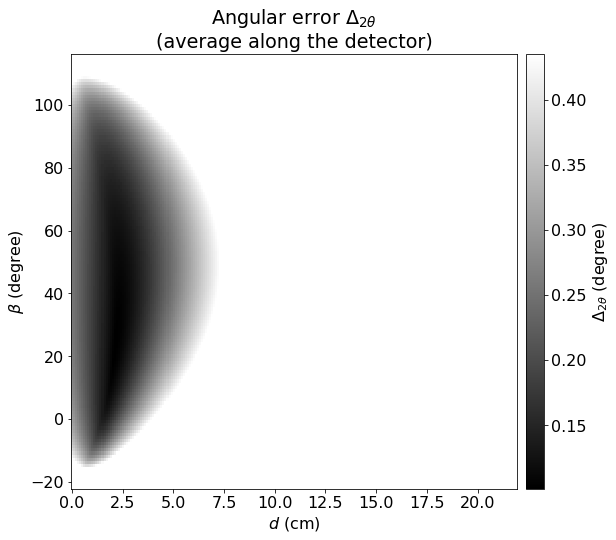

In [129]:
fig, ax = subplots(figsize = (8, 8))

im = ax.imshow(arr_error_total,
               extent = (d_min - d_step/2, d_max - d_step/2, beta_min - beta_step/2, beta_max - beta_step/2),
               aspect = 'auto', interpolation = 'none', cmap = 'gray',
               vmin = nanmin(arr_error_total), vmax = 0.05 * nanmax(arr_error_total))

cb = colorbar(im, ax = ax, cax = ax.inset_axes([1.02,0, 0.04, 1]), label = r'$\Delta_{2\theta}$ (degree)')
cb.ax.yaxis.set_offset_position('left')
ax.set_xlabel(r'$d$ (cm)')
ax.set_ylabel(r'$\beta$ (degree)')
ax.set_title('Angular error ' + r'$\Delta_{2\theta}$' + '\n(average along the detector)')
show()

In [130]:
idx_beta, idx_d = unravel_index(nanargmin(arr_error_total), arr_error_total.shape)
beta_min = arr_beta.flatten()[idx_beta]
d_min = arr_d.flatten()[idx_d]
beta_min, d_min

(23.34946683927501, 2.1)

a, s = 0.546, 7.193
beta = 23.34946683927501
d = 2.100 cm
i = 10
theta = 30
Df = 3.107 cm
Dp = 0.011 cm (2.185 channels)
Dtheta = 0.086 deg


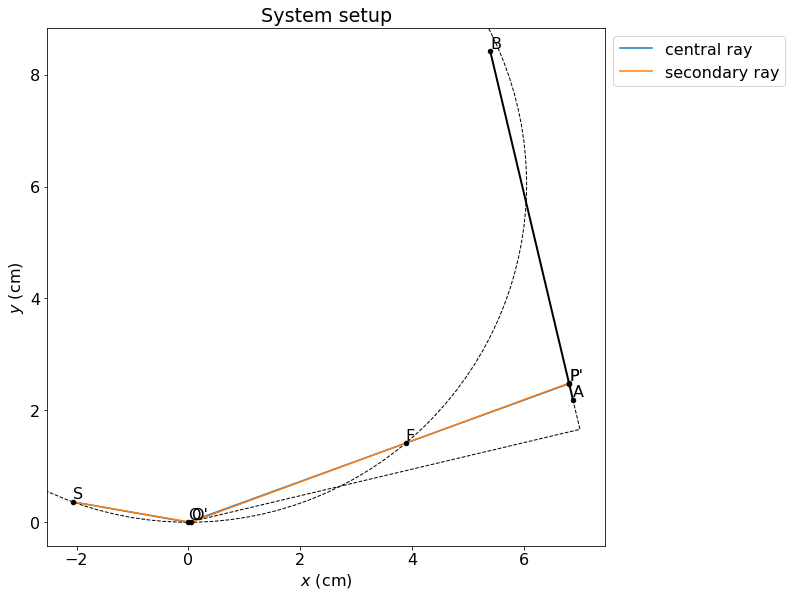

In [131]:
beta_plot = beta_min
d_plot = d_min
omega_plot = omega   # Deviation angle of the followed secondary ray

### Diffraction ###
#theta = (theta_min + theta_max) / 2
theta = 30

### Plot ###
rcParams['font.size'] = 16
plot_secondary_ray = True

###

a, s = a_s_from_beta(beta_plot, L, theta_min, theta_max)

### Plot system configuration ###

print(f'a, s = {a:.3f}, {s:.3f}')
print(f'beta = {beta_plot}')
print(f'd = {d_plot:.3f} cm')
print(f'i = {incident}')
print(f'theta = {theta}')
Delta_f, Delta_p, Delta_theta = error_defocus(theta, a, s, beta_plot, incident, d_plot, omega_plot)
print(f'Df = {Delta_f:.3f} cm')
print(f'Dp = {Delta_p:.3f} cm ({Delta_p / length_channel:.3f} channels)')
print(f'Dtheta = {Delta_theta:.3f} deg')

### Figure ###
fig, ax = subplots(figsize = (10, 10))
plot_experimental_setting(L, a, s, beta_plot, incident, d_plot, omega_plot, theta, ax, legend = True, secondary_ray = plot_secondary_ray)
show()

theta = 30 deg
p(P') = 0.303 cm
p(P'') = 0.281 cm
p(D') = 0.265 cm
p(D'') = 0.243 cm
Delta p = 0.030074199725023856 cm
Delta p = 0.030074199725023856 cm


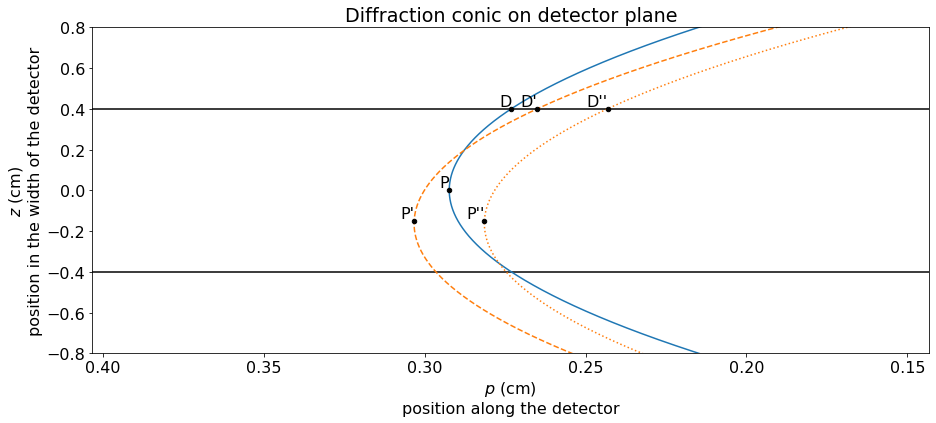

In [132]:
sigma_omega_plot = omega   # Angular disperion of the beam (direction 1)
sigma_psi_plot = psi   # Angular disperion of the beam (direction 2)

### Calculate intersection curve ###
arr_z = arange(- 20 * width_channel, 20 * width_channel, 0.0001)
arr_p = conic_diffraction_base(arr_z, theta, a, s, beta_plot)
Delta_z = ( d + s / cos(deg2rad(theta - beta_plot)) ) * tan(deg2rad(sigma_psi_plot))
arr_p1 = conic_diffraction(arr_z, theta, a, s, beta_plot, d_plot, incident, sigma_omega_plot, -sigma_psi_plot)
arr_p2 = conic_diffraction(arr_z, theta, a, s, beta_plot, d_plot, incident, -sigma_omega_plot, -sigma_psi_plot)

### Calculate coordinates and distances ###
x_P = angle_to_distance(theta, a, s, beta_plot)
x_D = conic_diffraction_base(width_channel/2, theta, a, s, beta_plot)[0]
x_P1 = conic_diffraction(0, theta, a, s, beta_plot, d_plot, incident, sigma_omega_plot, 0)[0]
x_D1 = conic_diffraction(width_channel/2, theta, a, s, beta_plot, d_plot, incident, sigma_omega_plot, -sigma_psi_plot)[0]
x_P2 = conic_diffraction(0, theta, a, s, beta_plot, d_plot, incident, -sigma_omega_plot, 0)[0]
x_D2 = conic_diffraction(width_channel/2, theta, a, s, beta_plot, d_plot, incident, -sigma_omega_plot, -sigma_psi_plot)[0]
Delta_p = 0.5 * (max(x_P1, x_D1, x_P2, x_D2) - min(x_P1, x_D1, x_P2, x_D2))
Delta_p_alt, _ = error_defocus_and_cone(width_channel, theta, a, s, beta_plot, d_plot, incident, sigma_omega_plot, sigma_psi_plot)

print(f'theta = {theta} deg')
print(f'p(P\') = {x_P1:.3f} cm')
print(f'p(P\'\') = {x_P2:.3f} cm')
print(f'p(D\') = {x_D1:.3f} cm')
print(f'p(D\'\') = {x_D2:.3f} cm')
print(f'Delta p = {Delta_p} cm')
print(f'Delta p = {Delta_p_alt} cm')

### Plot ###
fig, ax = subplots(figsize = (15, 6))
ax.plot([0, 0], [- width_channel/2, width_channel/2], c = 'black')
ax.plot([L, L], [- width_channel/2, width_channel/2], c = 'black')
ax.plot([0, L], [- width_channel/2, - width_channel/2], c = 'black')
ax.plot([0, L], [width_channel/2, width_channel/2], c = 'black')
ax.plot(arr_p[0], arr_z, c = 'tab:blue')
ax.plot(arr_p[1], arr_z, c = 'tab:blue')
ax.plot(arr_p1[0], arr_z, ls = '--', c = 'tab:orange')
ax.plot(arr_p2[0], arr_z, ls = ':', c = 'tab:orange')

ax.scatter(0, 0, c = 'black', s = 20, zorder = 2.5)
ax.annotate('A', (0, 0), ha = 'left', va = 'bottom')
ax.scatter(n_channels * length_channel, 0, c = 'black', s = 20, zorder = 2.5)
ax.annotate('B', (n_channels * length_channel, 0), ha = 'right', va = 'bottom')
list_letters = ['P', 'D', 'P\'', 'D\'', 'P\'\'', 'D\'\'']
list_coords = [(x_P, 0), (x_D, width_channel/2), (x_P1, -Delta_z), (x_D1, width_channel/2), (x_P2, -Delta_z), (x_D2, width_channel/2)]
for letter, coords in zip(list_letters, list_coords):
    ax.scatter(*coords, c = 'black', s = 20, zorder = 2.5)
    ax.annotate(letter, coords, ha = 'right', va = 'bottom')

#ax.set_aspect(1)
x_lim_complete = n_channels * length_channel * array([- 0.1, 1.1])
if (not isnan(x_D2)):
    x_lim_narrow = (x_D2 - 0.1, x_P1 + 0.1)
else:
    x_lim_narrow = (- 0.1 * n_channels * length_channel, x_P1 + 0.05)
#ax.set_xlim(n_channels * length_channel * array([- 0.1, 1.1]))
#ax.set_ylim(- 2 * width_channel, 2 * width_channel)
ax.set_xlim(x_lim_narrow)
ax.set_ylim(- 1 * width_channel, 1 * width_channel)

ax.invert_xaxis()
ax.set_xlabel(r'$p$ (cm)' + '\nposition along the detector')
ax.set_ylabel(r'$z$ (cm)' + '\nposition in the width of the detector')
ax.set_title('Diffraction conic on detector plane')
show()

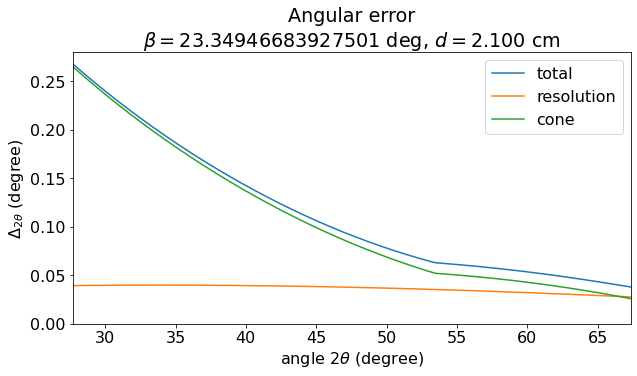

In [133]:
arr_channel_base = arange(0, n_channels, 1)
arr_theta_base = channel_to_angle(arr_channel_base, a, s, beta_plot, length_channel)

### Error from cone ###
# Varying: beta (--> a, s), theta (--> channel)
arr_theta = arr_theta_base
Delta_p, Delta_theta = error_defocus_and_cone(width_channel, arr_theta, a, s, beta_plot, d_plot, incident, omega, psi)
arr_error_cone = Delta_theta

### Error from defocus ###
# Varying: channel (--> theta)
arr_theta = arr_theta_base
arr_error_resolution = error_resolution(arr_theta, a, s, beta, length_channel)

### Total error ###
arr_error_total = sqrt(power(arr_error_cone, 2) + power(arr_error_resolution, 2))

###

fig, ax = subplots(figsize = (10, 5))
ax.plot(arr_theta_base, arr_error_total, label = 'total')
ax.plot(arr_theta_base, arr_error_resolution, label = 'resolution')
ax.plot(arr_theta_base, arr_error_cone, label = 'cone')
ax.legend(frameon = True)
ax.set_xlim(theta_min, theta_max)
ax.set_ylim(0, None)
ax.set_xlabel(r'angle $2 \theta$ (degree)')
ax.set_ylabel(r'$\Delta_{2\theta}$ (degree)')
ax.set_title('Angular error\n' + r'$\beta = $' + f'{beta_plot} deg' + r', $d = $' + f'{d_plot:.3f} cm')
show()